# The Battle of Neighborhoods - Applied Data Science Capstone Project

## Real estate in the Italian economic hub, Milan

## Introduction

The goal of this research is to classify the different areas of the city by category of venues and find any correlation with the real estate market.
The research will also evaluate how the presence of subway stations contributes to the diffusion of these venues and to the house prices.

Ultimately, the report should be able to guide a potential house buyer regarding:   
• what parts of the city have affordable houses compatibly with their budget  
• what areas have a high density of commercial or residential spaces  
• what areas are best served by public transport  
• what areas are the most fashionable

## Data  

• The data regarding real estate market prices will be scraped from the website of one of the largest real estate advertising websites (https://www.borsinoimmobiliare.it). Please notice that the scraped page contains already the average sale price per square meter for each area. Scraping the whole website for all listings would proved more detailed results but it is unfortunately not allowed by the T&Cs of the website.   
This data will be useful to understand which areas are affordable for a potential buyer.  
• The coordinates of each subway station are provided on the official website of the City Council (https://dati.comune.milano.it/dataset/ds535_atm-fermate-linee-metropolitane/resource/dd6a770a-b321-44f0-b58c-9725d84409bb).  
This data will be useful to understand what areas are best served by public transportation, by plotting the location of each station on a map of the city.  
• The information regarding what venues are present in each area will be collected thanks to Foursquare.  
This data will be used to form clusters by types of venues. This should help the potential buyer to understand what areas most suit his interests (i.e. a buyer with small children might prefer to move to a residential area, instead a young couple might prefer one with many bars and restaurants).

## Importing libraries

In [1]:
# Importing urllib.request to fetch the HTML from the URL
import urllib.request

# Importing the BeautifulSoup library to parse HTML and XML documents
from bs4 import BeautifulSoup

import pandas as pd # library for data analsysis

# Importing Nominatim to later convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# library to handle JSON files
import json 

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


import requests

import numpy as np

print('Libraries imported')

Libraries imported


## Scraping the real estate listing website for sale price data in Milan

In [2]:
# Defining the url of the website from which the house prices will be scraped
url = 'https://www.borsinoimmobiliare.it/quotazioni-immobiliari/Lombardia/Milano-Provincia/Milano'
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

In [3]:
# parse the HTML from the URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")
# Inspecting the webpage it is evident the table of interest is the only with width='100%'
table = soup.find('table', width='100%')
table

<table border="0" cellpadding="5" cellspacing="0" style="margin-bottom: 20px" width="100%">
<tr class="bluBorsino" style="font-size:16px !important;color:#ffffff;">
<td style="padding:10px"> Elenco Zone Centrali </td>
<td align="right" colspan="2" style="padding:25px"></td>
</tr>
<tr bgcolor="#f6f6f6" class="centrale">
<td align="left" bgcolor="#f6f6f6" height="30" style="font-size:12px; color:#000;"><a href="quotazioni-immobiliari/Lombardia/Milano-Provincia/Milano/ABRUZZI__EUSTACHI__PLINIO__" style="color:#000000;text-transform:capitalize;"><img height="8" src="images/marker.png" width="4"/> abruzzi, eustachi, plinio -</a></td>
<td align="center" height="18" style="color:#2B3B5F; font-size:11px;"><span style="color:#5f5f5f;">
                  2.870                </span></td>
<!--<td align="center" style="color:#2B3B5F; font-size:11px;"><span style="color:#3BB3E0;"><strong>64000</strong></span> (-34%)</td>-->
<td align="center" bgcolor="#f6f6f6" height="18" style="font-size:11px; col

In [4]:
# Defining 2 empty lists to be appended with neighborhood names and average house prices
neighborhood=[]
sale_price=[]

# Append scraped data to each list
for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)>0:
        neighborhood.append(cells[0].text)
        sale_price.append(cells[1].text)

### Creating a dataframe with scraped data

In [5]:
# Creating a dataframe. Please notice the price is expressed in thousands of € per square meter
df=pd.DataFrame({"Area": neighborhood, "Price": sale_price})
df.head()

,Area,Price
0,Elenco Zone Centrali,
1,"abruzzi, eustachi, plinio -",\n 2.870
2,"amendola, monte rosa, buonarroti",\n 3.385
3,"brera, duomo, cordusio, torino",\n 6.141
4,"cadorna, monti, boccaccio -",\n 4.888


In [6]:
# Let's see the shape of the dataframe
df.shape

(60, 2)

## Pre-processing and Visualizing Data

In [7]:
# Setting pandas to display all rows
pd.set_option('display.max_rows', 169)

In [8]:
# Cleaning names by removing '\n'and '-'
df = df.replace('\n','', regex=True)
df = df.replace('-','', regex=True)

df.head()

,Area,Price
0,Elenco Zone Centrali,
1,"abruzzi, eustachi, plinio",2.870
2,"amendola, monte rosa, buonarroti",3.385
3,"brera, duomo, cordusio, torino",6.141
4,"cadorna, monti, boccaccio",4.888


In [9]:
# Different areas in the dataframe are grouped by same average house price, splitting them and showing only one for each row
df['Area'] = df.Area.apply(lambda x: x[0:].split(','))
df = df.explode('Area')

df.head()

,Area,Price
0,Elenco Zone Centrali,
1,abruzzi,2.870
1,eustachi,2.870
1,plinio,2.870
2,amendola,3.385


In [10]:
# Replacing missing values with NaN
df['Price'].replace('', np.nan, inplace=True)
df['Area'].replace('', np.nan, inplace=True)
# Drop rows with NaN
df.dropna(subset=['Price'], inplace=True)
df.dropna(subset=['Area'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Area,Price
0,abruzzi,2.870
1,eustachi,2.870
2,plinio,2.870
3,amendola,3.385
4,monte rosa,3.385
5,buonarroti,3.385
6,brera,6.141
7,duomo,6.141
8,cordusio,6.141
9,torino,6.141


In [11]:
# Checking types of columns
print('The type of column Price is ' + str(df.Price.dtype))
print('The type of column Area is ' + str(df.Area.dtype))

The type of column Price is object
The type of column Area is object


In [12]:
# Converting price values from object to float
df['Price'] = df['Price'].apply(pd.to_numeric, downcast='float', errors='coerce')

## Let's see how prices vary and how many areas are in each range of price

In [13]:
# Creating 4 range of prices of equal dimension and naming them
df['PriceRange'] = pd.cut(df['Price'], bins=4, 
                              labels=['Low', 'Medium', 'High', 'Very High'])
df

,Area,Price,PriceRange
0,abruzzi,2.870,Low
1,eustachi,2.870,Low
2,plinio,2.870,Low
3,amendola,3.385,Medium
4,monte rosa,3.385,Medium
5,buonarroti,3.385,Medium
6,brera,6.141,High
7,duomo,6.141,High
8,cordusio,6.141,High
9,torino,6.141,High


In [14]:
# Counting how many areas are in each price range
df['PriceRange'].value_counts()

Low          112
Medium        34
High          17
Very High      4
Name: PriceRange, dtype: int64

Text(0.5, 1.0, 'Number of areas by price range')

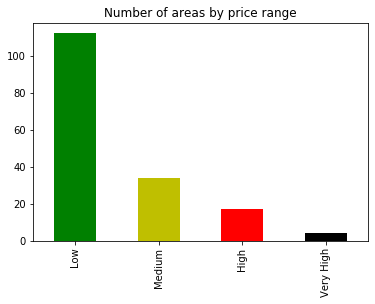

In [15]:
# Visualizing how many areas are in each price range
df['PriceRange'].value_counts()[:20].plot(kind='bar', color=['g', 'y', 'r', 'k'])
plt.title('Number of areas by price range')

## Let's find out how distance from the city center affects prices

In [16]:
# Using geopy to obtain coordinates for each area
latitude = np.zeros(df.shape[0])
longitude = np.zeros(df.shape[0])

geolocator = Nominatim(user_agent="milan")

for idx in range(df.shape[0]):
    address = df['Area'].loc[idx] + ', Milano, Lombardia'
    
    location = geolocator.geocode(address)
    if location is None:
        print ('{} could not be geocoded'.format(address))
        latitude[idx] = None
        longitude[idx] = None
    else:
        latitude[idx] = location.latitude
        longitude[idx] = location.longitude

 s. eufemia, Milano, Lombardia could not be geocoded
 washigton, Milano, Lombardia could not be geocoded
 cermentate, Milano, Lombardia could not be geocoded


In [17]:
# Some locations could not be geocoded, it appears evident there is a spelling issue. Correcting mispelled names
df = df.replace('s. eufemia','sant eufemia', regex=True)
df = df.replace('washigton','washington', regex=True)
df = df.replace('cermentate','cermenate', regex=True)

In [18]:
# Using geopy to obtain coordinates for each area after correcting mispelling
latitude = np.zeros(df.shape[0])
longitude = np.zeros(df.shape[0])
full_address = []
geolocator = Nominatim(user_agent="milan")

for idx in range(df.shape[0]):
    address = df['Area'].loc[idx] + ', Milano, Lombardia'
    
    location = geolocator.geocode(address)
    if location is None:
        print ('{} could not be geocoded'.format(address))
        latitude[idx] = None
        longitude[idx] = None
        
    else:
        latitude[idx] = location.latitude
        longitude[idx] = location.longitude
        full_address.append(location.address)

In [19]:
# Creating a new dataframe with geocoded information
district_coordinates = df
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates['Neighborhood'] = full_address
district_coordinates

,Area,Price,PriceRange,Latitude,Longitude,Neighborhood
0,abruzzi,2.870,Low,45.586192,8.901479,"Via Abruzzi, San Bernardino, Oltrestazione, Le..."
1,eustachi,2.870,Low,45.477964,9.214939,"Via Bartolomeo Eustachi, Buenos Aires - Venezi..."
2,plinio,2.870,Low,45.601802,8.904847,"Via Plinio, San Martino, Legnano, Milano, Lomb..."
3,amendola,3.385,Medium,45.473679,9.150969,"Amendola, Piazza Giovanni Amendola, De Angeli ..."
4,monte rosa,3.385,Medium,45.404598,8.998472,"Cascina Rosa, Gaggiano, Milano, Lombardia, Italia"
5,buonarroti,3.385,Medium,45.470402,9.155292,"Buonarroti, Piazza Michelangelo Buonarroti, Sa..."
6,brera,6.141,High,45.471519,9.187735,"Brera, Municipio 1, Milano, Lombardia, 20121, ..."
7,duomo,6.141,High,45.464138,9.188555,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M..."
8,cordusio,6.141,High,45.465832,9.186094,"Cordusio, Municipio 1, Milano, Lombardia, Italia"
9,torino,6.141,High,45.598833,8.901365,"Via Torino, La Flora, Oltrestazione, Legnano, ..."


In [20]:
# Dropping areas for which address was not found

district_coordinates = district_coordinates[district_coordinates.Neighborhood != 'Milano, Lombardia, Italia']
district_coordinates.reset_index(drop=True, inplace=True)

The new dataframe contains latitude, longitude and full address for each neighborhood.

In [21]:
# Let's see the new dataframe
district_coordinates.head()

,Area,Price,PriceRange,Latitude,Longitude,Neighborhood
0,abruzzi,2.870,Low,45.586192,8.901479,"Via Abruzzi, San Bernardino, Oltrestazione, Le..."
1,eustachi,2.870,Low,45.477964,9.214939,"Via Bartolomeo Eustachi, Buenos Aires - Venezi..."
2,plinio,2.870,Low,45.601802,8.904847,"Via Plinio, San Martino, Legnano, Milano, Lomb..."
3,amendola,3.385,Medium,45.473679,9.150969,"Amendola, Piazza Giovanni Amendola, De Angeli ..."
4,monte rosa,3.385,Medium,45.404598,8.998472,"Cascina Rosa, Gaggiano, Milano, Lombardia, Italia"


## Finding distance from the city center, Piazza Duomo

In [22]:
# Finding the coordinated of Milan's center 
address_duomo = 'Duomo di Milano, Milan, Italy'

geolocator = Nominatim(user_agent="milan_explorer")
location = geolocator.geocode(address_duomo)
latitude_duomo = location.latitude
longitude_duomo = location.longitude
print('The geographical coordinates of Piazza Duomo are {}, {}.'.format(latitude_duomo, longitude_duomo))

The geographical coordinates of Piazza Duomo are 45.46416835, 9.191621109614111.


In [23]:
# !pip install pyproj
from pyproj import Geod
# Distance will be measured on this ellipsoid - more accurate than a spherical method
wgs84_geod = Geod(ellps='WGS84') 

for index, row in district_coordinates.iterrows():
    
    def Distance(lat1,lon1,lat2,lon2):
      az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
      return dist

    lat1 = latitude_duomo
    lon1 = longitude_duomo
    lat2 = district_coordinates['Latitude']
    lon2 = district_coordinates['Longitude']

#Package as a dataframe
df_dist = pd.DataFrame({'lat1':lat1,'lon1':lon1,'lat2':lat2,'lon2':lon2})

#Add/update a column to the data frame with the distances (in metres)
district_coordinates['Distance'] = Distance(df_dist['lat1'].tolist(),df_dist['lon1'].tolist(),df_dist['lat2'].tolist(),df_dist['lon2'].tolist())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Assuming the potential buyers want to experience the city center we drop locations more than 5000 meters away from it.

In [24]:
# Dropping areas over 5000 meters away from city center
near_areas = district_coordinates[district_coordinates.Distance < 5000]
near_areas.reset_index(drop=True, inplace=True)

The new dataframe shows the distance from the city center in meters.

In [25]:
near_areas.head()

,Area,Price,PriceRange,Latitude,Longitude,Neighborhood,Distance
0,eustachi,2.870,Low,45.477964,9.214939,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",2382.374788
1,amendola,3.385,Medium,45.473679,9.150969,"Amendola, Piazza Giovanni Amendola, De Angeli ...",3350.134876
2,buonarroti,3.385,Medium,45.470402,9.155292,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",2924.288045
3,brera,6.141,High,45.471519,9.187735,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",871.618368
4,duomo,6.141,High,45.464138,9.188555,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",239.831797


In [26]:
# Saving to file
near_areas.to_csv("near_areas.csv", encoding='utf-8', index=False)

### Let's see how proximity to the city center affects the sale price.

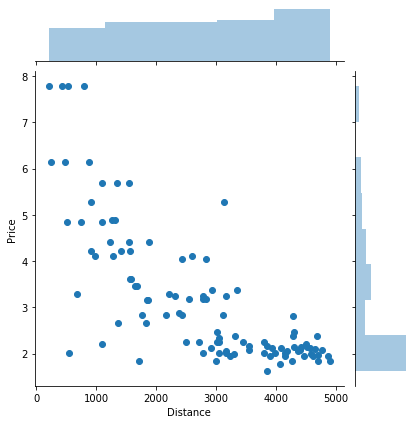

In [27]:
# Plotting price vs distance from city center
sns.jointplot(x='Distance', y='Price', data=near_areas[['Distance','Price']])

It appears evident a strong correlation between price and proximity to the city center.  
In order to further analyze this correlation boxplots will help to visually show the distribution of numerical data and skewness through displaying the data quartiles and averages.

In [28]:
# Creating 5 distance ranges to use for bloxplots
near_areas['DistanceRange'] = pd.cut(near_areas['Distance'], bins=5, 
                              labels=['1km', '2km', '3km', '4km', '5km'])
near_areas

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Area,Price,PriceRange,Latitude,Longitude,Neighborhood,Distance,DistanceRange
0,eustachi,2.870,Low,45.477964,9.214939,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",2382.374788,3km
1,amendola,3.385,Medium,45.473679,9.150969,"Amendola, Piazza Giovanni Amendola, De Angeli ...",3350.134876,4km
2,buonarroti,3.385,Medium,45.470402,9.155292,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",2924.288045,3km
3,brera,6.141,High,45.471519,9.187735,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",871.618368,1km
4,duomo,6.141,High,45.464138,9.188555,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",239.831797,1km
5,cordusio,6.141,High,45.465832,9.186094,"Cordusio, Municipio 1, Milano, Lombardia, Italia",470.183191,1km
6,cadorna,4.888,High,45.468195,9.176426,"Cadorna, Piazzale Luigi Cadorna, Castello, Mun...",1269.796805,2km
7,boccaccio,4.888,High,45.467783,9.175641,"Cadorna M1 M2, Via Giovanni Boccaccio, Castell...",1312.696399,2km
8,castello,4.107,Medium,45.469006,9.181218,"Castello, Municipio 1, Milano, Lombardia, Italia",975.189910,1km
9,melzi d`eril,4.107,Medium,45.475129,9.196404,"Palazzo Melzi d'Eril, Via Daniele Manin, Giard...",1274.263307,2km


The following boxplot clearly shows a rather large difference in the average price of properties located within 1000 meters and the others clearly indicating buyers are willing to pay a premium to live in very central spots. A less wide difference is seen among other categories while almost no difference is present between the price of those located in the 4-5km and over 5km range. 

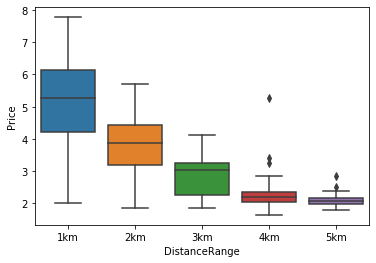

In [29]:
sns.boxplot(x='DistanceRange', y='Price', data=near_areas[['DistanceRange','Price']])

## Mapping

In order to produce a map which shows location and average price for each area we will use the coordinates found through Geocoder. In order to show price differences 4 bins will be created, associating a colour to each of them. Green colour will mark low prices, lighgreen will mark medium prices, orange will mark high prices and red very high prices.

In [30]:
# Create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[latitude_duomo, longitude_duomo], zoom_start=13)
# Divide dataframe in 4 bins according to price and assigning color code to each bin
near_areas['marker_color'] = pd.cut(near_areas['Price'], bins=4, 
                              labels=['green', 'lightgreen', 'orange', 'red'])
# Add markers to map
for index, row in near_areas.iterrows():
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']], 
        popup=row['Area'],
        icon=folium.Icon(color=row['marker_color'], icon="home", )).add_to(map_milan)  
map_milan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


The map confirms what anticipated by the boxplot, showing that most expensive areas point to the center.  
Let's see if the presence of a subway station has any impact on the sale price.

## Adding subway stations to the map

In [31]:
# Downloading GeoJson file from Milan's City website containing all subway lines
!wget --quiet https://dati.comune.milano.it/dataset/5d24ff16-26c7-4f3a-98dd-b5b8f0b65003/resource/df024fd8-9c4e-4e22-a39e-7e91295b7a7b/download/tpl_metropercorsi.geojson
# Downloading GeoJson file from Milan's City website containing all subway stops
!wget --quiet https://dati.comune.milano.it/dataset/b7344a8f-0ef5-424b-a902-f7f06e32dd67/resource/dd6a770a-b321-44f0-b58c-9725d84409bb/download/tpl_metrofermate.geojson    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [32]:
# defining geojson file
milan_sub_lines = r'tpl_metropercorsi.geojson' 
milan_sub_stops = r'tpl_metrofermate.geojson'

In [33]:
# Adding subway path and stops to the map
map_milan_subway = folium.Map(location=[latitude_duomo, longitude_duomo], zoom_start=13)
# Divide dataframe in 4 bins according to price and assigning color code to each bin
near_areas['marker_color'] = pd.cut(near_areas['Price'], bins=4, 
                              labels=['green', 'lightgreen', 'orange', 'red'])
# Add markers to map
for index, row in near_areas.iterrows():
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']], 
        popup=row['Area'],
        icon=folium.Icon(color=row['marker_color'], icon="home", )).add_to(map_milan_subway) 

folium.GeoJson(milan_sub_lines, name='Subway Lines').add_to(map_milan_subway)
folium.GeoJson(milan_sub_stops, name='Subway Stops').add_to(map_milan_subway)
# Adding layer control    
folium.LayerControl().add_to(map_milan_subway)
map_milan_subway

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


The map above shows that several lines pass through the city center and the most expensive. Several areas located in proximity of a line belong to the cheapest category suggesting therefore that proximity to a subway line might not have a big influence on house prices.

## Researching venues with Foursquare

Define Foursquare Credentials and Version

In [34]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O4A31BXGDRNL152LBPVYTVA5XB2DZPQZU43PNDQR3MCKMPHC
CLIENT_SECRET:4OZOLKEV0A40EHS0JZGSJUMIOFLCZUQAGCYV514043Y0V5RT


To get venues near every area we create the following function

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

In [36]:
milan_venues = getNearbyVenues(names=near_areas['Neighborhood'],
                                   latitudes=near_areas['Latitude'],
                                   longitudes=near_areas['Longitude']
                              )

Via Bartolomeo Eustachi, Buenos Aires - Venezia, Città Studi, Milano, Lombardia, 20100, Italia
Amendola, Piazza Giovanni Amendola, De Angeli - Monte Rosa, Tre Torri-Fiera, Milano, Lombardia, 20149, Italia
Buonarroti, Piazza Michelangelo Buonarroti, San Pietro in Sala, Municipio 8, Milano, Lombardia, 20145, Italia
Brera, Municipio 1, Milano, Lombardia, 20121, Italia
Duomo, Piazza del Duomo, Duomo, Municipio 1, Milano, Lombardia, 20121, Italia
Cordusio, Municipio 1, Milano, Lombardia, Italia
Cadorna, Piazzale Luigi Cadorna, Castello, Municipio 1, Milano, Lombardia, 20123, Italia
Cadorna M1 M2, Via Giovanni Boccaccio, Castello, Porta Magenta, Milano, Lombardia, 20123, Italia
Castello, Municipio 1, Milano, Lombardia, Italia
Palazzo Melzi d'Eril, Via Daniele Manin, Giardini Porta Venezia, Porta Nuova, Milano, Lombardia, 20121, Italia
Sarpi, Municipio 8, Milano, Lombardia, 20154, Italia
Cenisio, Via Cenisio, Ghisolfa, Bullona, Milano, Lombardia, 20154, Italia
Via Giulio Cesare Procaccini, Sa

Let's check the size of the new dataframe

In [37]:
print(milan_venues.shape)
milan_venues.head()

(3920, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",45.477964,9.214939,Orsonero,45.477673,9.211384,Coffee Shop
1,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",45.477964,9.214939,POPOROYA SUSHI YA,45.475730,9.214790,Sushi Restaurant
2,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",45.477964,9.214939,Pizzeria Marghe,45.479318,9.212058,Pizza Place
3,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",45.477964,9.214939,Bao House,45.477110,9.216541,Chinese Restaurant
4,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",45.477964,9.214939,Kanji Evo,45.477237,9.212279,Japanese Restaurant


In [38]:
# Saving the dataframe into a csv file to avoid hitting Foursquare calls limit
milan_venues.to_csv("milano_venues.csv", encoding='utf-8', index=False)

Let's count how many venues were returned for each neighborhood

In [39]:
# Loading csv if all Foursquare calls were used for the day
#milan_venues = pd.read_csv('milano_venues.csv')
#milan_venues.head()

### Fashion district

In order to find out where the famous fashion district is located and how it impacts house prices only venues markes as boutique will be saved in a separate dataframe. Their location is then plotted on a map to show how house prices are in their proximity.

In [61]:
boutiques = milan_venues[milan_venues.Category == 'Boutique']
boutiques.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
163,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",45.471519,9.187735,Armani,45.470443,9.192732,Boutique
171,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",45.471519,9.187735,Ermenegildo Zegna Boutique,45.469819,9.192989,Boutique
176,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",45.471519,9.187735,Kenzo,45.469763,9.192539,Boutique
195,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",45.464138,9.188555,Prada,45.465600,9.189968,Boutique
206,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",45.464138,9.188555,Louis Vuitton,45.465224,9.191796,Boutique


In [60]:
map_boutiques = folium.Map(location=[latitude_duomo, longitude_duomo], zoom_start=15)


# Add markers to mapmap_boutiques
for index, row in boutiques.iterrows():
    
    folium.Marker(
        location=[row['Venue Latitude'], row['Venue Longitude']], 
        popup=row['Venue'],
        icon=folium.Icon(color='black', icon="credit-card", )).add_to(map_boutiques)  

# Add house markers to map
for index, row in near_areas.iterrows():
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']], 
        popup=row['Area'],
        icon=folium.Icon(color=row['marker_color'], icon="home", )).add_to(map_boutiques)    

    
map_boutiques

The map above clearly shows how the majority of most exclusive clothing shops are located in the most expensive areas of the city.

In [42]:
milan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
Neighborhood,,,,,,
"Amati!, Via Marcello Malpighi, Buenos Aires - Venezia, Porta Venezia, Milano, Lombardia, 20129, Italia",50,50,50,50,50,50
"Amendola, Piazza Giovanni Amendola, De Angeli - Monte Rosa, Tre Torri-Fiera, Milano, Lombardia, 20149, Italia",29,29,29,29,29,29
"Argonne, Via Umberto Masotto, Corsica, Acquabella, Milano, Lombardia, 20133, Italia",41,41,41,41,41,41
"Barona, Quartiere Sant'Ambrogio, Milano, Lombardia, Italia",5,5,5,5,5,5
"Bausan, Via Filippo Baldinucci, Bovisa, Milano, Lombardia, 20158, Italia",30,30,30,30,30,30
"Borgo San Gottardo, Porta Ticinese, Milano, Lombardia, 20136, Italia",50,50,50,50,50,50
"Bovisa, Milano, Lombardia, Italia",33,33,33,33,33,33
"Brenta, Corso Lodi, San Luigi, Corvetto, Milano, Lombardia, 20139, Italia",36,36,36,36,36,36
"Brera, Municipio 1, Milano, Lombardia, 20121, Italia",50,50,50,50,50,50


Let's find how many unique categories were returned

In [43]:
print('There are {} uniques categories.'.format(len(milan_venues['Category'].unique())))

There are 253 uniques categories.


## Analyzing Each Neighborhood

In [44]:
# one hot encoding
milan_onehot = pd.get_dummies(milan_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
milan_onehot['Neighborhood'] = milan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [milan_onehot.columns[-1]] + list(milan_onehot.columns[:-1])
milan_onehot = milan_onehot[fixed_columns]

milan_onehot.head()

,Neighborhood,Abruzzo Restaurant,Accessories Store,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
milan_onehot.shape

(3920, 254)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [46]:
milan_grouped = milan_onehot.groupby('Neighborhood').mean().reset_index()
milan_grouped

,Neighborhood,Abruzzo Restaurant,Accessories Store,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Amati!, Via Marcello Malpighi, Buenos Aires - ...",0.000000,0.020000,0.020000,0.000000,0.000000,0.020000,0.040000,0.000000,0.000000,...,0.00,0.02,0.000000,0.000000,0.00,0.000000,0.020000,0.020000,0.00,0.00
1,"Amendola, Piazza Giovanni Amendola, De Angeli ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
2,"Argonne, Via Umberto Masotto, Corsica, Acquabe...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.024390,0.024390,0.00,0.00
3,"Barona, Quartiere Sant'Ambrogio, Milano, Lomba...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
4,"Bausan, Via Filippo Baldinucci, Bovisa, Milano...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.033333,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
5,"Borgo San Gottardo, Porta Ticinese, Milano, Lo...",0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,...,0.00,0.00,0.020000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
6,"Bovisa, Milano, Lombardia, Italia",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
7,"Brenta, Corso Lodi, San Luigi, Corvetto, Milan...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
8,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.040000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.040000,0.000000,0.00,0.00
9,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.00,0.00


### Let's find out which are the top 10 venues for each neighborhood

In [47]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = milan_grouped['Neighborhood']

for ind in np.arange(milan_grouped.shape[0]):
    
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(milan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Amati!, Via Marcello Malpighi, Buenos Aires - ...",Italian Restaurant,Seafood Restaurant,Ice Cream Shop,Hotel,Pizza Place,Café,Art Gallery,Gastropub,Mediterranean Restaurant,Garden
1,"Amendola, Piazza Giovanni Amendola, De Angeli ...",Italian Restaurant,Plaza,Café,Pizza Place,Hotel,Asian Restaurant,Brewery,Sushi Restaurant,Park,Fountain
2,"Argonne, Via Umberto Masotto, Corsica, Acquabe...",Pizza Place,Café,Bakery,Seafood Restaurant,Convenience Store,Italian Restaurant,Chinese Restaurant,Bus Stop,Hotel,Pub
3,"Barona, Quartiere Sant'Ambrogio, Milano, Lomba...",Trattoria/Osteria,Theater,Soccer Field,Athletics & Sports,Café,Yoga Studio,Flea Market,Flower Shop,Food,Food & Drink Shop
4,"Bausan, Via Filippo Baldinucci, Bovisa, Milano...",Italian Restaurant,Café,Piadineria,Ice Cream Shop,Bakery,Sicilian Restaurant,Pizza Place,Brewery,Bookstore,Steakhouse


# Cluster Neighborhoods

Running k-means clustering with k=3 to form 3 clusters. It was tried to use k=2, 4 and 5 but no significant information could be extracted from it, therefore k=3 seems to be the best choice.

In [49]:
# set number of clusters
kclusters = 3

milan_grouped_clustering = milan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Amati!, Via Marcello Malpighi, Buenos Aires - ...",Italian Restaurant,Seafood Restaurant,Ice Cream Shop,Hotel,Pizza Place,Café,Art Gallery,Gastropub,Mediterranean Restaurant,Garden
1,1,"Amendola, Piazza Giovanni Amendola, De Angeli ...",Italian Restaurant,Plaza,Café,Pizza Place,Hotel,Asian Restaurant,Brewery,Sushi Restaurant,Park,Fountain
2,0,"Argonne, Via Umberto Masotto, Corsica, Acquabe...",Pizza Place,Café,Bakery,Seafood Restaurant,Convenience Store,Italian Restaurant,Chinese Restaurant,Bus Stop,Hotel,Pub
3,0,"Barona, Quartiere Sant'Ambrogio, Milano, Lomba...",Trattoria/Osteria,Theater,Soccer Field,Athletics & Sports,Café,Yoga Studio,Flea Market,Flower Shop,Food,Food & Drink Shop
4,1,"Bausan, Via Filippo Baldinucci, Bovisa, Milano...",Italian Restaurant,Café,Piadineria,Ice Cream Shop,Bakery,Sicilian Restaurant,Pizza Place,Brewery,Bookstore,Steakhouse
5,1,"Borgo San Gottardo, Porta Ticinese, Milano, Lo...",Cocktail Bar,Ice Cream Shop,Plaza,Hotel,Italian Restaurant,Music Venue,Breakfast Spot,Spa,Brewery,Middle Eastern Restaurant
6,0,"Bovisa, Milano, Lombardia, Italia",Café,Italian Restaurant,Platform,Piadineria,Pizza Place,Sandwich Place,Steakhouse,Paper / Office Supplies Store,Brewery,College Cafeteria
7,0,"Brenta, Corso Lodi, San Luigi, Corvetto, Milan...",Italian Restaurant,Pizza Place,Japanese Restaurant,Plaza,Café,Dessert Shop,Gym / Fitness Center,Supermarket,Spa,Fried Chicken Joint
8,1,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",Hotel,Italian Restaurant,Ice Cream Shop,Boutique,Café,Wine Bar,Bakery,Art Museum,Cocktail Bar,Theater
9,1,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",Italian Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place,Plaza,Asian Restaurant,Clothing Store,Café,Shoe Store,Salon / Barbershop


In [51]:
# Creating a dataframe with the columns of interest
milan_merged = near_areas[['Neighborhood', 'Price', 'DistanceRange', 'Latitude', 'Longitude']]
milan_merged.head()

,Neighborhood,Price,DistanceRange,Latitude,Longitude
0,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",2.870,3km,45.477964,9.214939
1,"Amendola, Piazza Giovanni Amendola, De Angeli ...",3.385,4km,45.473679,9.150969
2,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",3.385,3km,45.470402,9.155292
3,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",6.141,1km,45.471519,9.187735
4,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",6.141,1km,45.464138,9.188555


In [52]:
# Merging milan_grouped with milan_merged to add latitude/longitude, price and distance from center for each neighborhood
milan_merged = milan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

milan_merged

,Neighborhood,Price,DistanceRange,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Via Bartolomeo Eustachi, Buenos Aires - Venezi...",2.870,3km,45.477964,9.214939,1,Italian Restaurant,Dessert Shop,Sandwich Place,Pizza Place,Hotel,Chinese Restaurant,Steakhouse,Beer Bar,Japanese Restaurant,Miscellaneous Shop
1,"Amendola, Piazza Giovanni Amendola, De Angeli ...",3.385,4km,45.473679,9.150969,1,Italian Restaurant,Plaza,Café,Pizza Place,Hotel,Asian Restaurant,Brewery,Sushi Restaurant,Park,Fountain
2,"Buonarroti, Piazza Michelangelo Buonarroti, Sa...",3.385,3km,45.470402,9.155292,1,Italian Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place,Plaza,Asian Restaurant,Clothing Store,Café,Shoe Store,Salon / Barbershop
3,"Brera, Municipio 1, Milano, Lombardia, 20121, ...",6.141,1km,45.471519,9.187735,1,Hotel,Italian Restaurant,Ice Cream Shop,Boutique,Café,Wine Bar,Bakery,Art Museum,Cocktail Bar,Theater
4,"Duomo, Piazza del Duomo, Duomo, Municipio 1, M...",6.141,1km,45.464138,9.188555,1,Ice Cream Shop,Hotel,Plaza,Coffee Shop,Monument / Landmark,Gourmet Shop,Bakery,Café,Cocktail Bar,Boutique
5,"Cordusio, Municipio 1, Milano, Lombardia, Italia",6.141,1km,45.465832,9.186094,1,Plaza,Hotel,Ice Cream Shop,Monument / Landmark,Bakery,Gourmet Shop,Italian Restaurant,Coffee Shop,Cocktail Bar,Café
6,"Cadorna, Piazzale Luigi Cadorna, Castello, Mun...",4.888,2km,45.468195,9.176426,1,Italian Restaurant,Sandwich Place,Café,Plaza,Ice Cream Shop,Dessert Shop,Art Gallery,Theater,Gift Shop,Bistro
7,"Cadorna M1 M2, Via Giovanni Boccaccio, Castell...",4.888,2km,45.467783,9.175641,1,Italian Restaurant,Ice Cream Shop,Café,Art Gallery,Wine Bar,Pizza Place,Dessert Shop,Museum,Coffee Shop,Historic Site
8,"Castello, Municipio 1, Milano, Lombardia, Italia",4.107,1km,45.469006,9.181218,1,Italian Restaurant,Plaza,Hotel,Theater,Café,Ice Cream Shop,Sandwich Place,Dessert Shop,Bakery,Gift Shop
9,"Palazzo Melzi d'Eril, Via Daniele Manin, Giard...",4.107,2km,45.475129,9.196404,1,Hotel,Italian Restaurant,Park,Art Gallery,Café,Ice Cream Shop,Bistro,Gym,Japanese Restaurant,Bookstore


### Creating a map showing the clusters.

In [53]:
# create map
map_clusters = folium.Map(location=[latitude_duomo, longitude_duomo], zoom_start=13)


# set colors
rainbow = ['red', 'blue','green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(milan_merged['Latitude'], milan_merged['Longitude'], milan_merged['Neighborhood'], milan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clusters in detail

#### Cluster 1

In [54]:
cluster1 = milan_merged.loc[milan_merged['Cluster Labels'] == 0, milan_merged.columns[[1] + list(range(5, milan_merged.shape[1]))]]
cluster1

,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,2.255,0,Pizza Place,Hotel,Italian Restaurant,Thai Restaurant,Event Space,Seafood Restaurant,Food & Drink Shop,Café,Student Center,Sushi Restaurant
12,2.255,0,Italian Restaurant,Pizza Place,Restaurant,Ice Cream Shop,Seafood Restaurant,Wine Bar,Bistro,Trattoria/Osteria,Gym,Brazilian Restaurant
15,5.274,0,Café,Pub,Pizza Place,Ramen Restaurant,Cocktail Bar,Chinese Restaurant,Seafood Restaurant,Burger Joint,Ice Cream Shop,Jazz Club
18,3.469,0,Pizza Place,Italian Restaurant,Seafood Restaurant,Cocktail Bar,Bakery,Boutique,Street Art,Gift Shop,Market,Restaurant
31,3.174,0,Supermarket,Italian Restaurant,Pizza Place,Café,Snack Place,Hardware Store,Asian Restaurant,Chinese Restaurant,Restaurant,Breakfast Spot
34,3.603,0,Café,Italian Restaurant,Pub,Pizza Place,Cocktail Bar,Seafood Restaurant,Ice Cream Shop,Tram Station,Japanese Restaurant,Bistro
41,2.826,0,Café,Boutique,Pizza Place,Italian Restaurant,Pastry Shop,Burger Joint,Seafood Restaurant,Sandwich Place,Plaza,Piadineria
42,2.826,0,Pizza Place,Tram Station,Italian Restaurant,Asian Restaurant,Ice Cream Shop,Sushi Restaurant,Fruit & Vegetable Store,Café,Kebab Restaurant,Sandwich Place
45,3.240,0,Pub,Seafood Restaurant,Café,Pizza Place,Italian Restaurant,Burger Joint,Bistro,Japanese Restaurant,Jazz Club,Mediterranean Restaurant
47,2.657,0,Café,Tram Station,Pizza Place,Restaurant,Italian Restaurant,Sandwich Place,Cocktail Bar,Lounge,Bed & Breakfast,Park


#### Cluster 2

In [55]:
cluster2 = milan_merged.loc[milan_merged['Cluster Labels'] == 1, milan_merged.columns[[1] + list(range(5, milan_merged.shape[1]))]]
cluster2

,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2.870,1,Italian Restaurant,Dessert Shop,Sandwich Place,Pizza Place,Hotel,Chinese Restaurant,Steakhouse,Beer Bar,Japanese Restaurant,Miscellaneous Shop
1,3.385,1,Italian Restaurant,Plaza,Café,Pizza Place,Hotel,Asian Restaurant,Brewery,Sushi Restaurant,Park,Fountain
2,3.385,1,Italian Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place,Plaza,Asian Restaurant,Clothing Store,Café,Shoe Store,Salon / Barbershop
3,6.141,1,Hotel,Italian Restaurant,Ice Cream Shop,Boutique,Café,Wine Bar,Bakery,Art Museum,Cocktail Bar,Theater
4,6.141,1,Ice Cream Shop,Hotel,Plaza,Coffee Shop,Monument / Landmark,Gourmet Shop,Bakery,Café,Cocktail Bar,Boutique
5,6.141,1,Plaza,Hotel,Ice Cream Shop,Monument / Landmark,Bakery,Gourmet Shop,Italian Restaurant,Coffee Shop,Cocktail Bar,Café
6,4.888,1,Italian Restaurant,Sandwich Place,Café,Plaza,Ice Cream Shop,Dessert Shop,Art Gallery,Theater,Gift Shop,Bistro
7,4.888,1,Italian Restaurant,Ice Cream Shop,Café,Art Gallery,Wine Bar,Pizza Place,Dessert Shop,Museum,Coffee Shop,Historic Site
8,4.107,1,Italian Restaurant,Plaza,Hotel,Theater,Café,Ice Cream Shop,Sandwich Place,Dessert Shop,Bakery,Gift Shop
9,4.107,1,Hotel,Italian Restaurant,Park,Art Gallery,Café,Ice Cream Shop,Bistro,Gym,Japanese Restaurant,Bookstore


#### Cluster 3

In [56]:
cluster3 = milan_merged.loc[milan_merged['Cluster Labels'] == 2, milan_merged.columns[[1] + list(range(5, milan_merged.shape[1]))]]
cluster3

,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,1.943,2,Arts & Crafts Store,Pet Store,Yoga Studio,Film Studio,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Fast Food Restaurant


### Observations

Cluster 1 is characterized by a high density of bars, restaurants, hotels and venues such as museums and theatres. This cluster includes the boutiques of the famous fashion district and includes the most expensive area of the city.  
Cluster 2 is a more residential area, yet shows large presence of italian food restaurants, which is quite normal in Italy.  
Cluster 3 includes more periferal areas, characterized by markets and shops less likely to be found in large numbers in the city center. It is most likely a periferal residential area.

## Mapping clusters against house prices

In [57]:
map_milan_final = folium.Map(location=[latitude_duomo, longitude_duomo], zoom_start=13)
# Divide dataframe in 4 bins according to price and assigning color code to each bin
near_areas['marker_color'] = pd.cut(near_areas['Price'], bins=4, 
                              labels=['green', 'lightgreen', 'orange', 'red'])
# Add price markers to map
for index, row in near_areas.iterrows():
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], 
        popup=row['Area'],
        color=row['marker_color'] ).add_to(map_milan_final)  


# add cluster markers to the map
markers_colors = []
# set colors
rainbow = ['red', 'blue','green']

for lat, lon, poi, cluster in zip(milan_merged['Latitude'], milan_merged['Longitude'], milan_merged['Neighborhood'], milan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_milan_final)    
    
    
map_milan_final

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Recommendations

In order to produce more accurate results it would be advisable to collect house sale prices directly from individual listings, if allowed (several websites offer non-free API services). Some degree of limitation is also posed by Foursquare's API which in its free version only offers a limited amount of calls.

# Conclusions

The map above shows that the most expensive areas are those near the center and with the highest density of shops and services. Buyers on a restricted budget who want to experience the city center might however still be able to find affordable houses in near proximity to the most central parts of the city. In conclusion house prices are mainly influenced by proximity to the city center and in particular to the famous fashion square.